# Galaxy Morphology Classification with Deep Learning
**Author:** Tom Barkley
**Date:** 2025

## Project Overview
This project aims to classify galaxies into different morphological types (Spiral, Elliptical, Irregular) using Deep Learning (Convolutional Neural Networks). The dataset is sourced from the **Galaxy Zoo** challenge.

### Objectives:
1. Load and preprocess galaxy images.
2. Analyze class distribution and labels.
3. Train a CNN to predict galaxy morphology.

## 1. Setup and Path Configuration
Begin by importing necessary libraries and verifying that our file paths point correctly to the downloaded image dataset.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from PIL import Image

# --- CONFIGURATION ---
# We use '..' to go up one level from 'src' to the root, then into 'data'
DATA_DIR = os.path.join("..", "data")
IMAGES_DIR = os.path.join(DATA_DIR, "images_train")
CATALOG_FILE = os.path.join(DATA_DIR, "training_solutions_rev1.csv")

# Verify paths work
print(f"Data Directory: {os.path.abspath(DATA_DIR)}")
print(f"Images Directory: {os.path.abspath(IMAGES_DIR)}")

# Check if we can see the files
if os.path.exists(IMAGES_DIR):
    files = os.listdir(IMAGES_DIR)
    print(f"Success! Found {len(files)} files in the image folder.")
    print(f"Sample file: {files[0]}")
else:
    print("ERROR: Images directory not found. Check your folder structure.")
    

Data Directory: c:\Dev\Projects\Galaxy_Morphology_Project\data
Images Directory: c:\Dev\Projects\Galaxy_Morphology_Project\data\images_train
Success! Found 61578 files in the image folder.
Sample file: 100008.jpg


## 2. Load Training Lables
The labels are stored in a CSV file. Each row corresponds to a specific "GalaxyID and contain probabilites for various morphological features of types of galaxies

In [7]:
# Check file readability
try: 
    df = pd.read_csv(CATALOG_FILE)
    print("CSV loaded successfully.")
    print(f"TOTAL GALAXIES: {df.shape[0]}")
    display(df.head())
except Exception as e: 
    print(f"Error loading CSV: {e}")

CSV loaded successfully.
TOTAL GALAXIES: 61578


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## 3. Visual Sanity Check
Before processing, we visualize random samples from the dataset to ensure the images align with the IDs in the catalog.

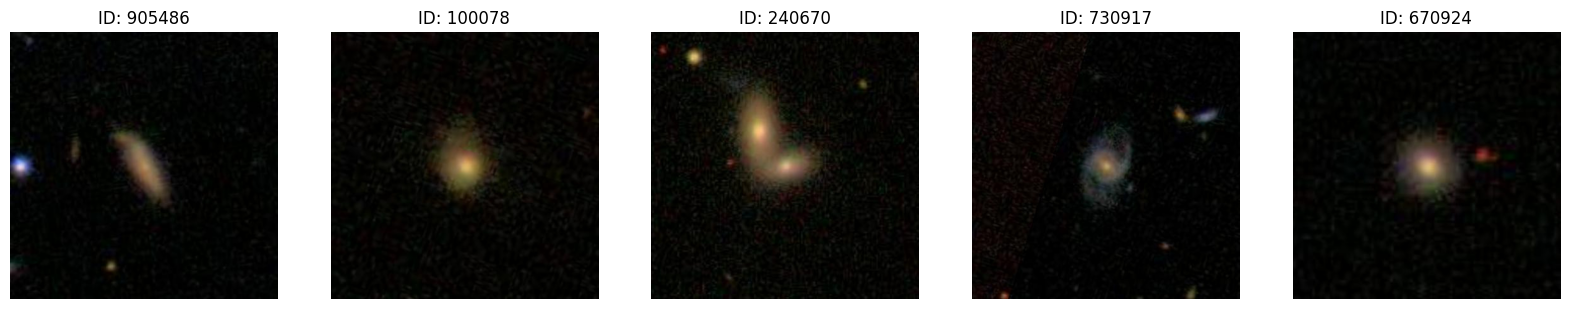

In [8]:
def show_random_galaxies(df, folder_path, num_to_show=5):
    plt.figure(figsize=(20, 5))
    
    # Pick random indices
    random_indices = random.sample(range(len(df)), num_to_show)
    
    for i, idx in enumerate(random_indices):
        row = df.iloc[idx]
        galaxy_id = int(row['GalaxyID'])
        
        # Construct the full image path
        img_name = f"{galaxy_id}.jpg"
        img_path = os.path.join(folder_path, img_name)
        
        # Create subplot
        plt.subplot(1, num_to_show, i + 1)
        
        try:
            # Load and display image
            img = Image.open(img_path)
            plt.imshow(img)
            plt.title(f"ID: {galaxy_id}")
            plt.axis('off')
        except FileNotFoundError:
            # If image is missing, show a placeholder text
            plt.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
            plt.title(f"ID: {galaxy_id} (Missing)")
            plt.axis('off')
            
    plt.show()

# Run the function
if 'df' in locals():
    show_random_galaxies(df, IMAGES_DIR)

## 4. Data Preprocessing: Cropping and Resizing
The raw images are 424x424 pixels, but the galaxy of interest is usually centered with a significant amount of empty background space. 

To improve training efficiency, we will:
1. **Center Crop:** Extract the central region where the galaxy is located.
2. **Resize:** Downscale the image to a manageable size (e.g., 64x64) for the neural network.

The code below allows us to experiment with different crop sizes to ensure we don't cut off important features like spiral arms.

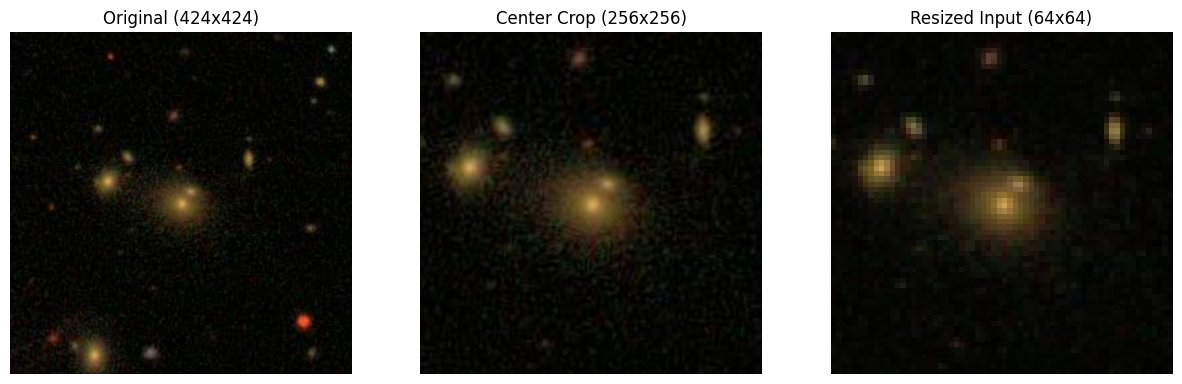

In [9]:
from PIL import ImageOps

def process_image_preview(img_path, crop_size=256, final_size=64):
    """
    1. Loads image
    2. Crops the center square (crop_size x crop_size)
    3. Resizes down to (final_size x final_size)
    """
    img = Image.open(img_path)
    original_dim = img.size
    
    # 1. Center Crop Calculation
    left = (original_dim[0] - crop_size)/2
    top = (original_dim[1] - crop_size)/2
    right = (original_dim[0] + crop_size)/2
    bottom = (original_dim[1] + crop_size)/2
    
    img_cropped = img.crop((left, top, right, bottom))
    
    # 2. Resize
    img_resized = img_cropped.resize((final_size, final_size))
    
    return img, img_cropped, img_resized

# --- EXPERIMENT WITH PARAMETERS ---
# Pick a random ID to test
sample_row = df.sample(1).iloc[0]

# --- FIX IS HERE: Force to int() ---
sample_id = int(sample_row['GalaxyID']) 

sample_path = os.path.join(IMAGES_DIR, f"{sample_id}.jpg")

# Settings to test
CROP_SIZE = 256  # Keep the middle 256 pixels
FINAL_SIZE = 64  # Shrink to 64x64 for the AI

# Run processing
try:
    orig, cropped, final = process_image_preview(sample_path, CROP_SIZE, FINAL_SIZE)

    # Plot the transformation
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(orig)
    axes[0].set_title(f"Original ({orig.size[0]}x{orig.size[1]})")

    axes[1].imshow(cropped)
    axes[1].set_title(f"Center Crop ({CROP_SIZE}x{CROP_SIZE})")

    axes[2].imshow(final)
    axes[2].set_title(f"Resized Input ({FINAL_SIZE}x{FINAL_SIZE})")

    for ax in axes: ax.axis('off')
    plt.show()
except FileNotFoundError:
    print(f"Error: Could not find file {sample_path}. Check if the ID exists in the folder.")

## 5. Splitting the Data
To evaluate our model fairly, we split the dataset:
* **Training Set (80%):** Used to teach the neural network.
* **Validation Set (20%):** Used to check performance on unseen data.

In [10]:
from sklearn.model_selection import train_test_split

# 1. Define the Targets (The answers we want the AI to predict)
# The CSV has 'GalaxyID' as the first column, and probability classes (Class1.1, etc.) for the rest.
classes = df.columns[1:] # All columns except GalaxyID
print(f"Number of target classes: {len(classes)}")

# 2. Split the DataFrame
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Verify the split
print("\nFirst 3 rows of Training Data:")
display(train_df.head(3))

Number of target classes: 37
Training samples: 49262
Validation samples: 12316

First 3 rows of Training Data:


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
18276,368831,0.32538,0.646283,0.028337,0.049275,0.597008,0.219799,0.377210,0.429407,0.167602,...,0.0,0.121344,0.164920,0.143143,0.0,0.429407,0.000000,0.0,0.0,0.000000
32582,577864,0.00000,0.999354,0.000646,0.000000,0.999354,0.408883,0.590471,0.999354,0.000000,...,0.0,0.134307,0.514811,0.350236,0.0,0.853276,0.146078,0.0,0.0,0.000000
49671,823070,0.77600,0.145000,0.079000,0.000000,0.145000,0.048285,0.096715,0.072500,0.072500,...,0.0,0.000000,0.048357,0.024143,0.0,0.048357,0.000000,0.0,0.0,0.024143


## 6. Building the Input Pipeline (tf.data)
We use `tf.data.Dataset` to handle data loading efficiently. This pipeline will:
1. Read the image file from the disk.
2. Decode the JPEG.
3. **Crop** the center 256x256 pixels.
4. **Resize** to 64x64 pixels.
5. Normalize pixel values (0-255 -> 0-1).

In [11]:
import tensorflow as tf

# Settings
IMG_SIZE = 64
CROP_SIZE = 256
BATCH_SIZE = 32 # How many images to process at once

def load_and_preprocess_image(path, label):
    # 1. Load the raw data
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # 2. Center Crop (The logic we tested)
    # tf.image.central_crop expects a fraction (0.0 to 1.0)
    # We calculate the fraction based on original 424 size
    crop_fraction = CROP_SIZE / 424.0 
    image = tf.image.central_crop(image, central_fraction=crop_fraction)
    
    # 3. Resize to final size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    # 4. Normalize (Convert 0-255 to 0.0-1.0)
    image = image / 255.0
    
    return image, label

# --- CREATE DATASETS ---

# 1. Prepare file paths and labels
train_paths = [os.path.join(IMAGES_DIR, f"{int(id)}.jpg") for id in train_df['GalaxyID']]
train_labels = train_df[classes].values

val_paths = [os.path.join(IMAGES_DIR, f"{int(id)}.jpg") for id in val_df['GalaxyID']]
val_labels = val_df[classes].values

# 2. Build the TensorFlow Datasets
# Training Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Dataset (No shuffling needed)
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data Pipeline created successfully!")
print(f"Batch size: {BATCH_SIZE}")
print(f"Image shape: {(IMG_SIZE, IMG_SIZE, 3)}")

Data Pipeline created successfully!
Batch size: 32
Image shape: (64, 64, 3)


## 7. Building the Model (CNN Architecture)
We define our **Hypothesis Class** by constructing a Convolutional Neural Network (CNN). 

Unlike a fully connected network that treats every pixel as independent, this architecture uses:
* **Conv2D Layers:** To detect local spatial features (edges, curves, spiral arms).
* **MaxPooling:** To reduce dimensionality and make the model invariant to small shifts (e.g., it shouldn't matter if the galaxy is slightly to the left).
* **Dropout:** To control the **Bias-Complexity Tradeoff**. As noted in *Understanding Machine Learning* (Section 5.2), simpler models generalize better. Dropout randomly "kills" neurons during training to prevent the model from memorizing the specific training images (Overfitting).

In [12]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        # --- Feature Extraction (The "Eye") ---
        # Layer 1: Detect basic edges
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer 2: Detect shapes (curves, circles)
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # Layer 3: Detect complex structures (spiral arms, bars)
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        # --- Classification Head (The "Brain") ---
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        
        # Dropout: Randomly disable 50% of neurons to force "robustness"
        # (See Chapter 26 on Stochastic Gradient Descent stability)
        layers.Dropout(0.5), 
        
        # Output: 37 neurons for the 37 Galaxy Zoo probability questions
        # We use 'sigmoid' because each output is an independent probability (0.0 to 1.0)
        layers.Dense(37, activation='sigmoid') 
    ])
    return model

# Initialize the hypothesis class
model = build_model()
print("Model architecture defined.")

Model architecture defined.


## 8. Compilation (Empirical Risk Minimization)
We configure the training process:
* **Optimizer:** `Adam` (an adaptive variant of Stochastic Gradient Descent). It navigates the loss landscape to find the minimum error.
* **Loss Function:** `mean_squared_error`. Since Galaxy Zoo labels are continuous probabilities (not just 0 or 1), we want to minimize the squared difference between our predicted probability and the crowdsourced consensus.

In [13]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae']) # Mean Absolute Error is easier to interpret for humans

# View the Complexity of our Hypothesis Class
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │         9,509 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,200,165 (8.39 MB)

 Trainable params: 2,200,165 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

## 9. Training the Model
We now train the network using `model.fit()`. 
* **Epochs:** We iterate through the entire dataset 10 times.
* **Validation Data:** After each epoch, the model is tested on the 20% of data it has never seen. This tells us if we are overfitting.
* **Callbacks:** We use `ModelCheckpoint` to save the best version of the model automatically, so we don't lose progress if the computer crashes.

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define where to save the best model
checkpoint_path = "galaxy_model_best.keras"

# Callbacks manage the training process
callbacks = [
    # Save the model whenever validation loss improves
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
    
    # Stop training early if validation loss stops improving for 3 epochs (prevents wasting time)
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

print("Starting training... (This may take a while)")

history = model.fit(
    train_ds,
    epochs=10,             # How many times to loop over the data
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1              # Show progress bar
)

print("Training complete!")

Starting training... (This may take a while)
Epoch 1/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - loss: 0.0211 - mae: 0.0881 - val_loss: 0.0148 - val_mae: 0.0701
Epoch 2/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - loss: 0.0145 - mae: 0.0706 - val_loss: 0.0128 - val_mae: 0.0654
Epoch 3/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.0128 - mae: 0.0656 - val_loss: 0.0114 - val_mae: 0.0611
Epoch 4/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - loss: 0.0120 - mae: 0.0632 - val_loss: 0.0110 - val_mae: 0.0595
Epoch 5/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - loss: 0.0114 - mae: 0.0616 - val_loss: 0.0106 - val_mae: 0.0581
Epoch 6/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - loss: 0.0109 - mae: 0.0602 - val_loss: 0.0107 - val_mae: 0.0584
Epoch 7/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - loss: 0.0105 - mae: 0.0591 - val_loss: 0.0105 - val_mae: 0.0573
Epoch 8/10
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - loss: 0.0102 - mae: 0.0581 - val_loss: 0.01

## 10. Visualizing Training History
We plot the **Loss Curves** to diagnose if the model is learning or overfitting.
* **Blue Line (Training Loss):** How well the model memorizes the training data.
* **Orange Line (Validation Loss):** How well the model generalizes to new data.

**Interpretation (based on Chapter 5 of "Understanding Machine Learning"):**
* **Underfitting:** Both lines are high and flat. The model is too simple (High Bias).
* **Overfitting:** Blue line goes down, but Orange line goes UP. The model is memorizing noise (High Variance).
* **Good Fit:** Both lines go down and stabilize together.

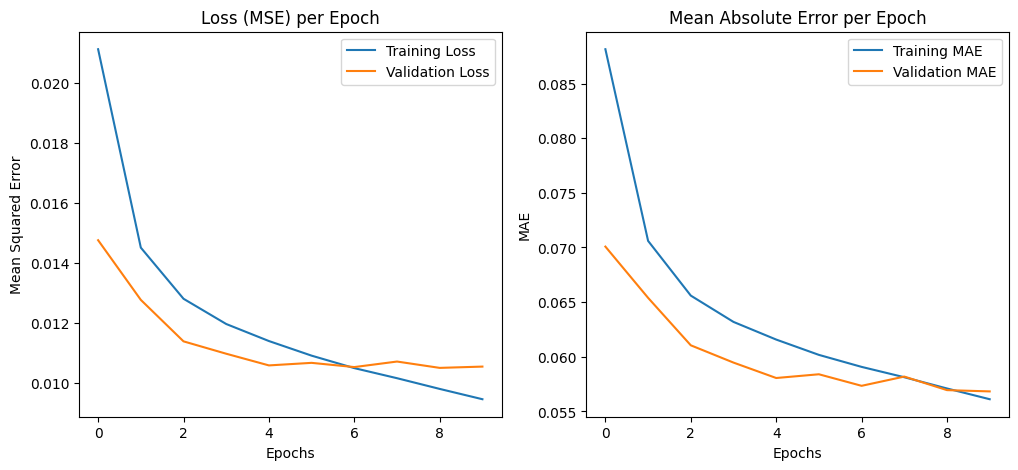

In [15]:
# Extract the history data
history_dict = history.history

# 1. Plot Loss (The Error)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss (MSE) per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

# 2. Plot MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error per Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

## 11a. Testing on New Galaxies
We pick random images from the Validation Set and compare the model's predictions against the actual Galaxy Zoo labels.

We focus on the first three classes for clarity:
* **Smooth:** Elliptical galaxies.
* **Features:** Spirals or disks.
* **Artifact:** Stars or junk data.

#TESTING CODE KEPT FOR PROSTERITY AND FUTURE UPDATES

import numpy as np

def visualize_prediction(dataset, model):
    # 1. Get a single batch of images and labels
    # 'iter' grabs the next batch from the data pipeline
    images, labels = next(iter(dataset))
    
    # 2. Make predictions
    predictions = model.predict(images)
    
    # 3. Plot the first 3 galaxies in the batch
    plt.figure(figsize=(15, 10))
    
    for i in range(3):
        # --- Image ---
        plt.subplot(3, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title("Galaxy Image")
        
        # --- Bar Chart (Truth vs Prediction) ---
        plt.subplot(3, 2, 2*i + 2)
        
        # We only look at the first 3 classes: Smooth, Features, Artifact
        categories = ['Smooth', 'Features', 'Artifact']
        truth = labels[i][:3]
        pred = predictions[i][:3]
        
        x = np.arange(len(categories))
        width = 0.35
        
        plt.bar(x - width/2, truth, width, label='Actual (Crowd)', color='gray')
        plt.bar(x + width/2, pred, width, label='AI Prediction', color='blue')
        
        plt.xticks(x, categories)
        plt.ylim(0, 1.1)
        plt.legend()
        plt.title("Probability Distribution")
        
    plt.tight_layout()
    plt.show()

# Run the visualizer
visualize_prediction(val_ds, model)

## 11. Testing on New Galaxies
We pick random images from the Validation Set and compare the model's predictions against the actual Galaxy Zoo labels.

We focus on the first three classes for clarity:
* **Smooth:** Elliptical galaxies.
* **Features:** Spirals or disks.
* **Artifact:** Stars or junk data.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


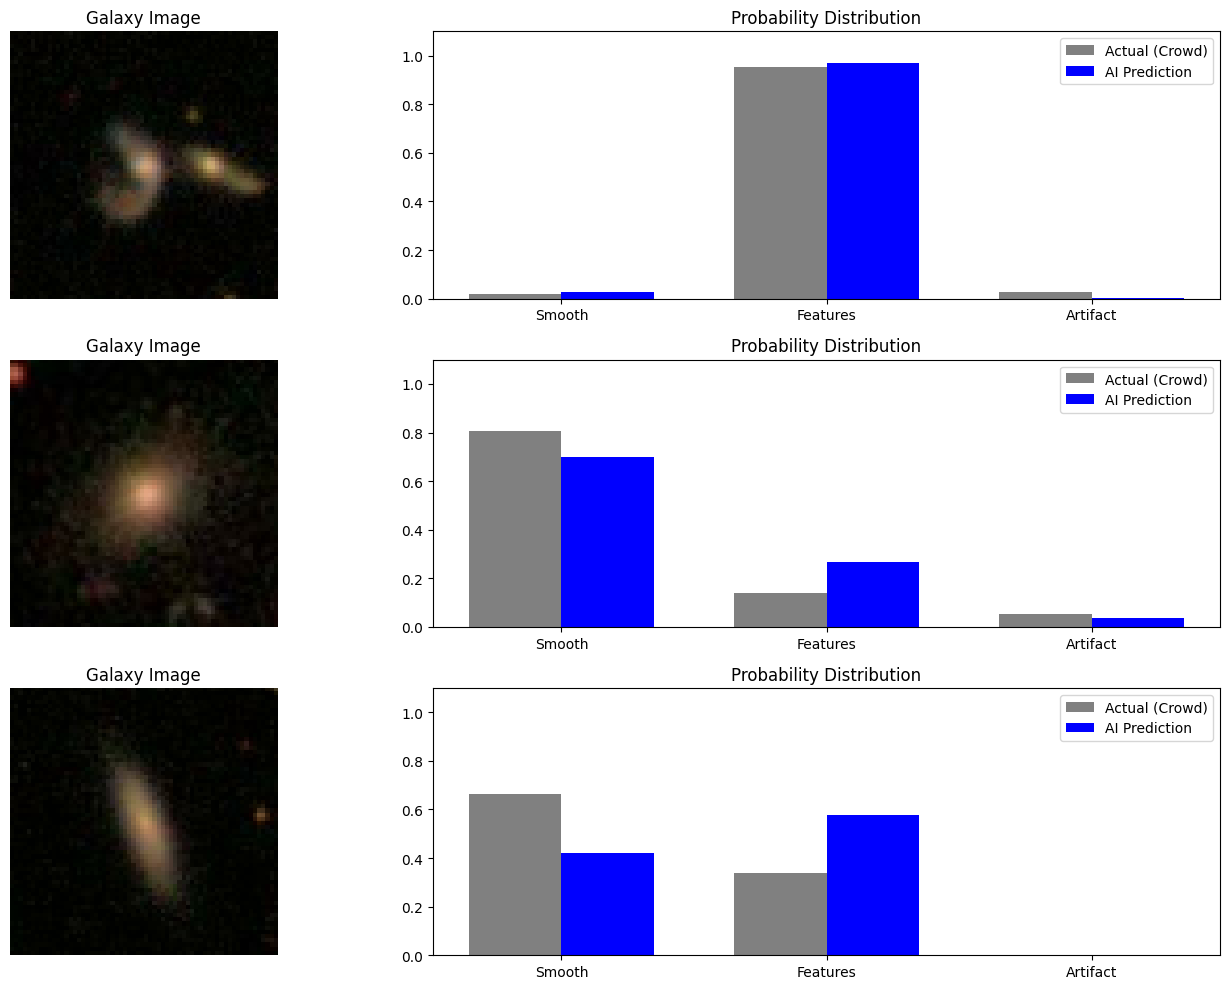

In [17]:
import numpy as np

def visualize_prediction(dataset, model):
    # 1. Get a single batch of images and labels
    # 'iter' grabs the next batch from the data pipeline
    images, labels = next(iter(dataset))
    
    # 2. Make predictions
    predictions = model.predict(images)
    
    # 3. Plot the first 3 galaxies in the batch
    plt.figure(figsize=(15, 10))
    
    for i in range(3):
        # --- Image ---
        plt.subplot(3, 2, 2*i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title("Galaxy Image")
        
        # --- Bar Chart (Truth vs Prediction) ---
        plt.subplot(3, 2, 2*i + 2)
        
        # We only look at the first 3 classes: Smooth, Features, Artifact
        categories = ['Smooth', 'Features', 'Artifact']
        truth = labels[i][:3]
        pred = predictions[i][:3]
        
        x = np.arange(len(categories))
        width = 0.35
        
        plt.bar(x - width/2, truth, width, label='Actual (Crowd)', color='gray')
        plt.bar(x + width/2, pred, width, label='AI Prediction', color='blue')
        
        plt.xticks(x, categories)
        plt.ylim(0, 1.1)
        plt.legend()
        plt.title("Probability Distribution")
        
    plt.tight_layout()
    plt.show()

# Run the visualizer
visualize_prediction(val_ds, model)